In [1]:
from utils.dataset import ProcessedDataset
from utils.dna import Genes
from pathlib import Path

import numpy as np 
import pandas as pd 
from tqdm import tqdm 

In [2]:
DATA_DIR = Path().absolute().parent / 'data'
dataset_name = 'dataset_2023_03_26'
DATASET_DIR = DATA_DIR / dataset_name
DATASET_DIR_EMEDDINGS = DATA_DIR / (dataset_name + '_embeddings')

In [3]:
dataset = ProcessedDataset(DATASET_DIR_EMEDDINGS)

100%|██████████| 10/10 [00:00<00:00, 186.52it/s]


## TODO:
Not all of the dnas have generated images.

In [4]:
images_fnames = list(DATA_DIR.glob('**/faces/*.png'))
dna_fnames = list(DATA_DIR.glob('**/dna/*.txt'))
matching_pairs = set([f.stem for f in images_fnames]) & set([f.stem for f in dna_fnames])
print(f"# of images: {len(images_fnames)}")
print(f"# of dna files: {len(dna_fnames)}")
print(f"# of matching pairs: {len(matching_pairs)}")


# of images: 14135
# of dna files: 14338
# of matching pairs: 9758


# Load matching embedding, dna pairs

In [5]:
def load_all_dna(dataset_dir: Path) -> dict[str, Genes]:
    dna_files = list(dataset_dir.glob('**/dna/*.txt'))
    return {dna_file.stem: Genes.from_ck_string(open(dna_file, 'r').read()) for dna_file in tqdm(dna_files)}

def find_matching_image(dna_file: Path, dataset_dir: Path) -> Path | None:
    file_name = dna_file.stem
    return next(dataset_dir.glob(f'**/faces/{file_name}.*'), None)

dnas = load_all_dna(DATASET_DIR)

100%|██████████| 14338/14338 [00:10<00:00, 1432.54it/s]


In [16]:
matching_files = np.array([Path(path).stem in dnas for path in dataset.paths])
print(f"% embeddings that has corresponding dna file: {matching_files.mean() * 100:.2f}%")

matching_dnas = []
for embedded_image_fname in dataset.paths:
    fname = Path(embedded_image_fname).stem
    if fname in dnas:
        matching_dnas.append(dnas[fname])

% embeddings that has corresponding dna file: 69.03%


### genes stats

In [7]:
sub_genes = [set(dna.flatten().keys()) for dna in matching_dnas]
all_genes = set.union(*sub_genes)
common_genes = set.intersection(*sub_genes)
diff_genes = all_genes - common_genes
print(f"Total number of sub genes: {len(all_genes)}")
print(f"Number of common genes: {len(common_genes)}")
print(f"Number of different genes: {len(diff_genes)}")

Total number of sub genes: 192
Number of common genes: 95
Number of different genes: 97


In [8]:
common_genes

{'bust_clothes',
 'cheek_forward_pos',
 'cheek_height_pos',
 'cheek_width_pos',
 'cheek_wrinkles_both_01',
 'chin_forward_pos',
 'chin_height_pos',
 'chin_width_pos',
 'ear_angle_pos',
 'ear_inner_shape_pos',
 'ear_outward_pos',
 'ear_size_pos',
 'eye_angle_pos',
 'eye_color[0]',
 'eye_color[1]',
 'eye_color[2]',
 'eye_color[3]',
 'eye_corner_depth_pos',
 'eye_depth_pos',
 'eye_distance_pos',
 'eye_fold_shape_pos',
 'eye_height_pos',
 'eye_lower_lid_def',
 'eye_shut_pos',
 'eye_size_pos',
 'eye_upper_lid_size_pos',
 'forehead_angle_pos',
 'forehead_brow_curve_pos',
 'forehead_brow_forward_pos',
 'forehead_brow_height_pos',
 'forehead_brow_inner_height_pos',
 'forehead_brow_outer_height_pos',
 'forehead_brow_width_pos',
 'forehead_height_pos',
 'forehead_roundness_pos',
 'forehead_width_pos',
 'hair_color[0]',
 'hair_color[1]',
 'hair_color[2]',
 'hair_color[3]',
 'head_height_pos',
 'head_profile_pos',
 'head_top_height_pos',
 'head_top_width_pos',
 'head_width_pos',
 'jaw_angle_pos',


In [11]:
diff_genes

{'asian_eyelashes',
 'avg_spacing_avg_thickness',
 'avg_spacing_high_thickness',
 'avg_spacing_low_thickness',
 'avg_spacing_lower_thickness',
 'body_fat_head_fat_full',
 'body_fat_head_fat_low',
 'body_fat_head_fat_medium',
 'body_hair_avg',
 'body_hair_avg_low_stubble',
 'body_hair_dense',
 'body_hair_dense_low_stubble',
 'body_hair_sparse',
 'body_hair_sparse_low_stubble',
 'body_shape_apple_full',
 'body_shape_apple_half',
 'body_shape_average',
 'body_shape_hourglass_full',
 'body_shape_hourglass_half',
 'body_shape_pear_full',
 'body_shape_pear_half',
 'body_shape_rectangle_full',
 'body_shape_rectangle_half',
 'body_shape_triangle_full',
 'body_shape_triangle_half',
 'brow_wrinkles_01',
 'brow_wrinkles_02',
 'brow_wrinkles_03',
 'brow_wrinkles_04',
 'bust_default',
 'bust_shape_1_full',
 'bust_shape_1_half',
 'bust_shape_2_full',
 'bust_shape_2_half',
 'bust_shape_3_full',
 'bust_shape_3_half',
 'bust_shape_4_full',
 'bust_shape_4_half',
 'cheek_def_01',
 'cheek_def_02',
 'cheek

### Vectorize dna

In [17]:
genes_to_use = sorted(common_genes)
vectorized_dnas = np.array([dna.asarray(keys=genes_to_use) for dna in matching_dnas])

In [18]:
vectorized_dnas.shape

(9758, 95)

# Correlation between genes and face features

In [19]:
# get embeddings of files that we have dna for
model2embeddings = {
    model_name: embeddings[matching_files] 
    for model_name, embeddings in dataset.model2embeddings.items()
}

In [21]:
assert len(vectorized_dnas) == len(matching_dnas)
assert len(vectorized_dnas[0]) == len(genes_to_use)
assert dataset.paths.shape[0] == dataset.alligned_images.shape[0]
assert all([len(model2embeddings[model_name]) == len(vectorized_dnas) for model_name in model2embeddings])

In [24]:
# calculate correlation between genes and embeddings for each model
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

model2correlations = {}
for model_name, embeddings in tqdm(model2embeddings.items()):
    model2correlations[model_name] = corr2_coeff(vectorized_dnas.T, embeddings.T)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/j2/83k2pfk133n_vkpjy9xj72c00000gn/T/ipykernel_8470/4273178190.py:12: RuntimeWarning: invalid value encountered in divide
  return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))
100%|██████████| 10/10 [00:00<00:00, 21.22it/s]


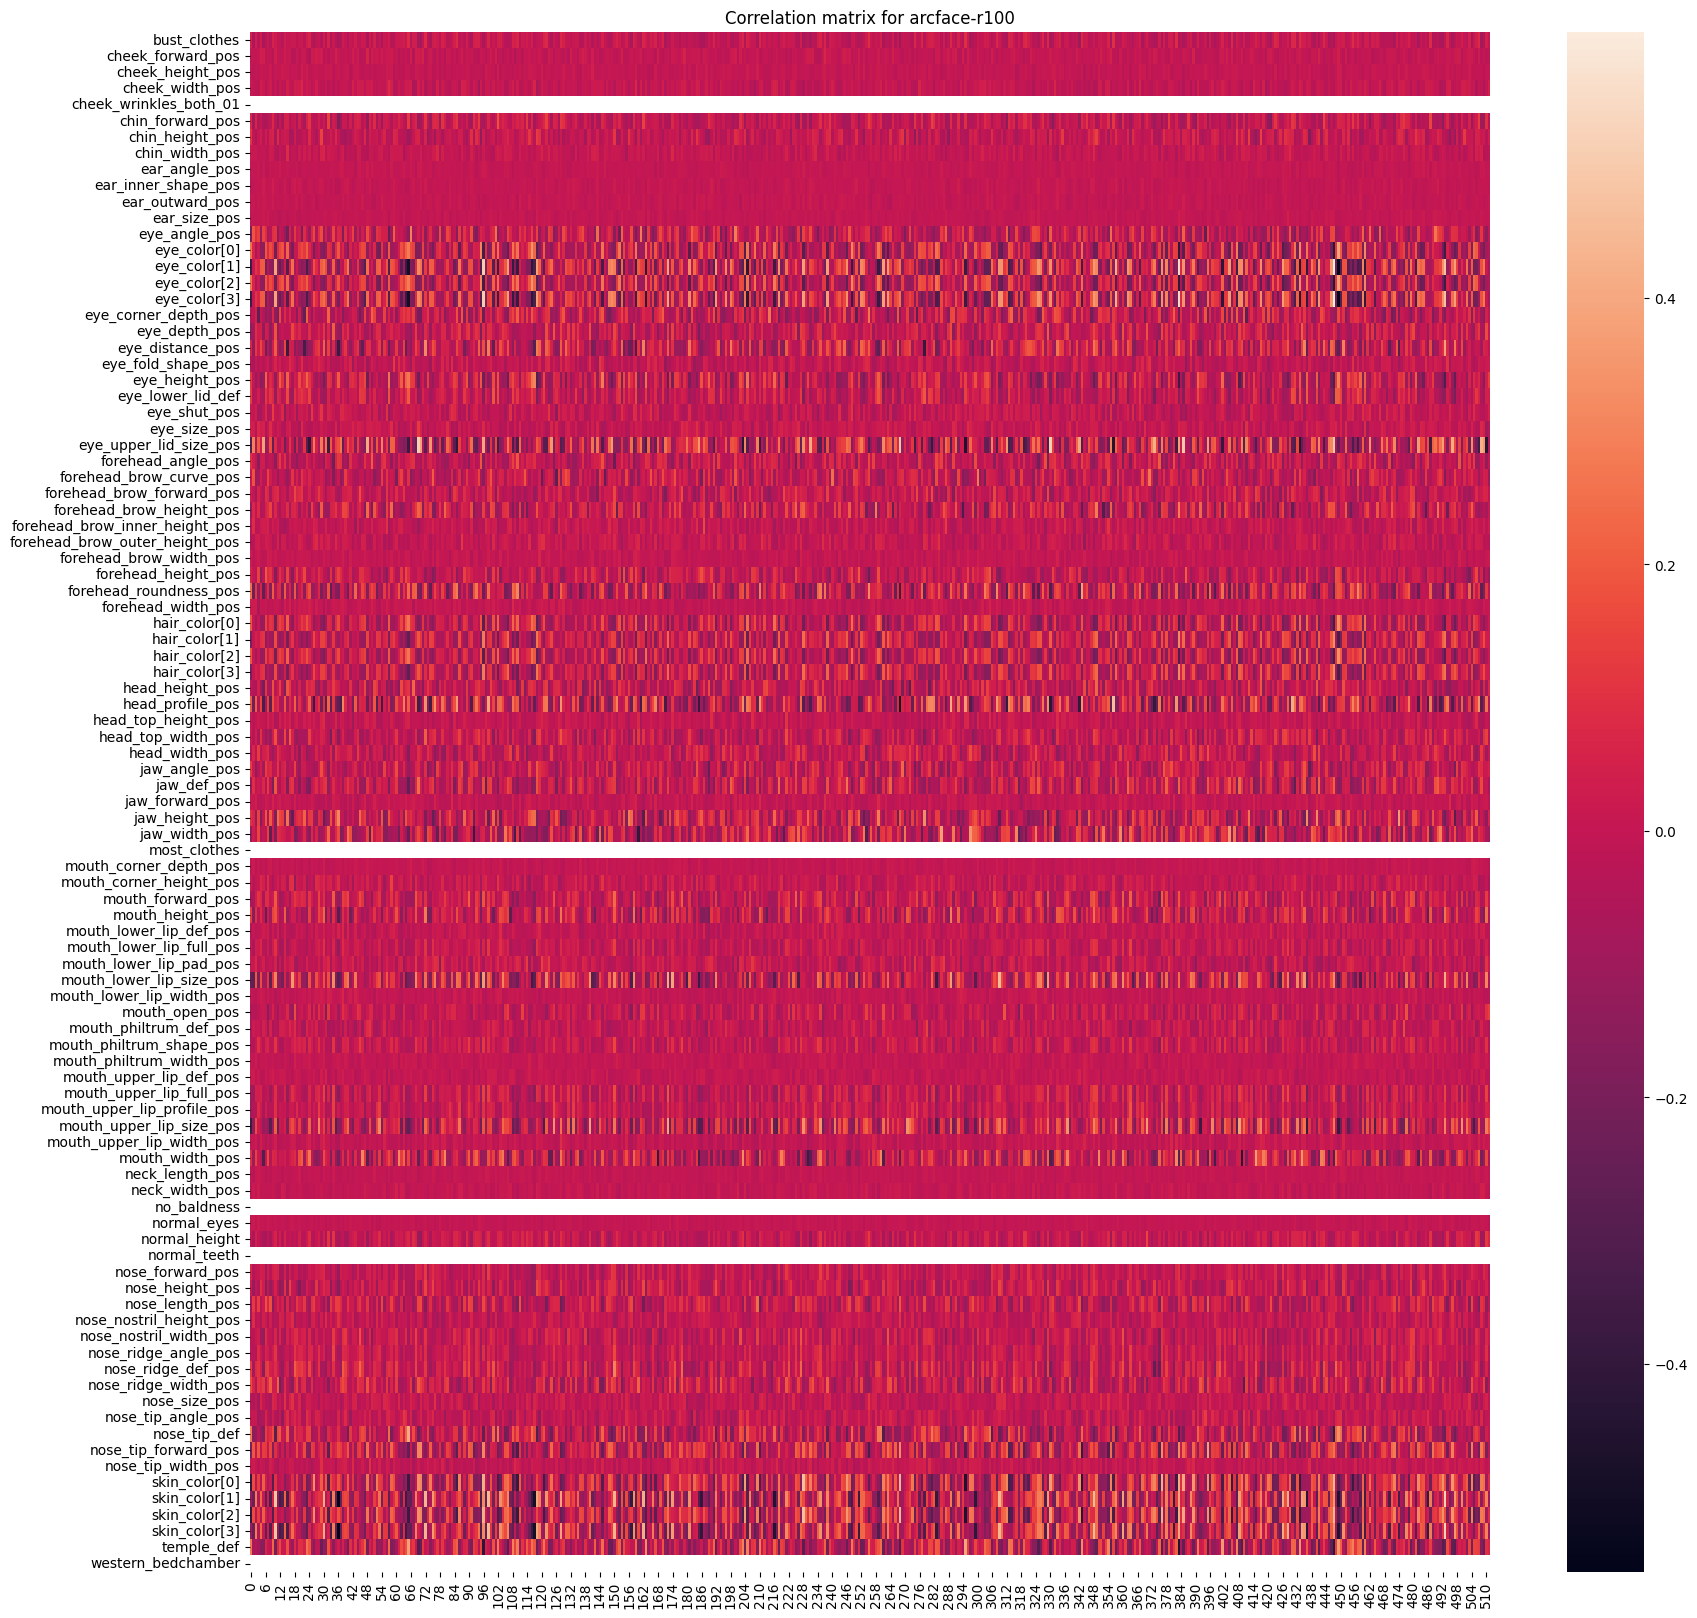

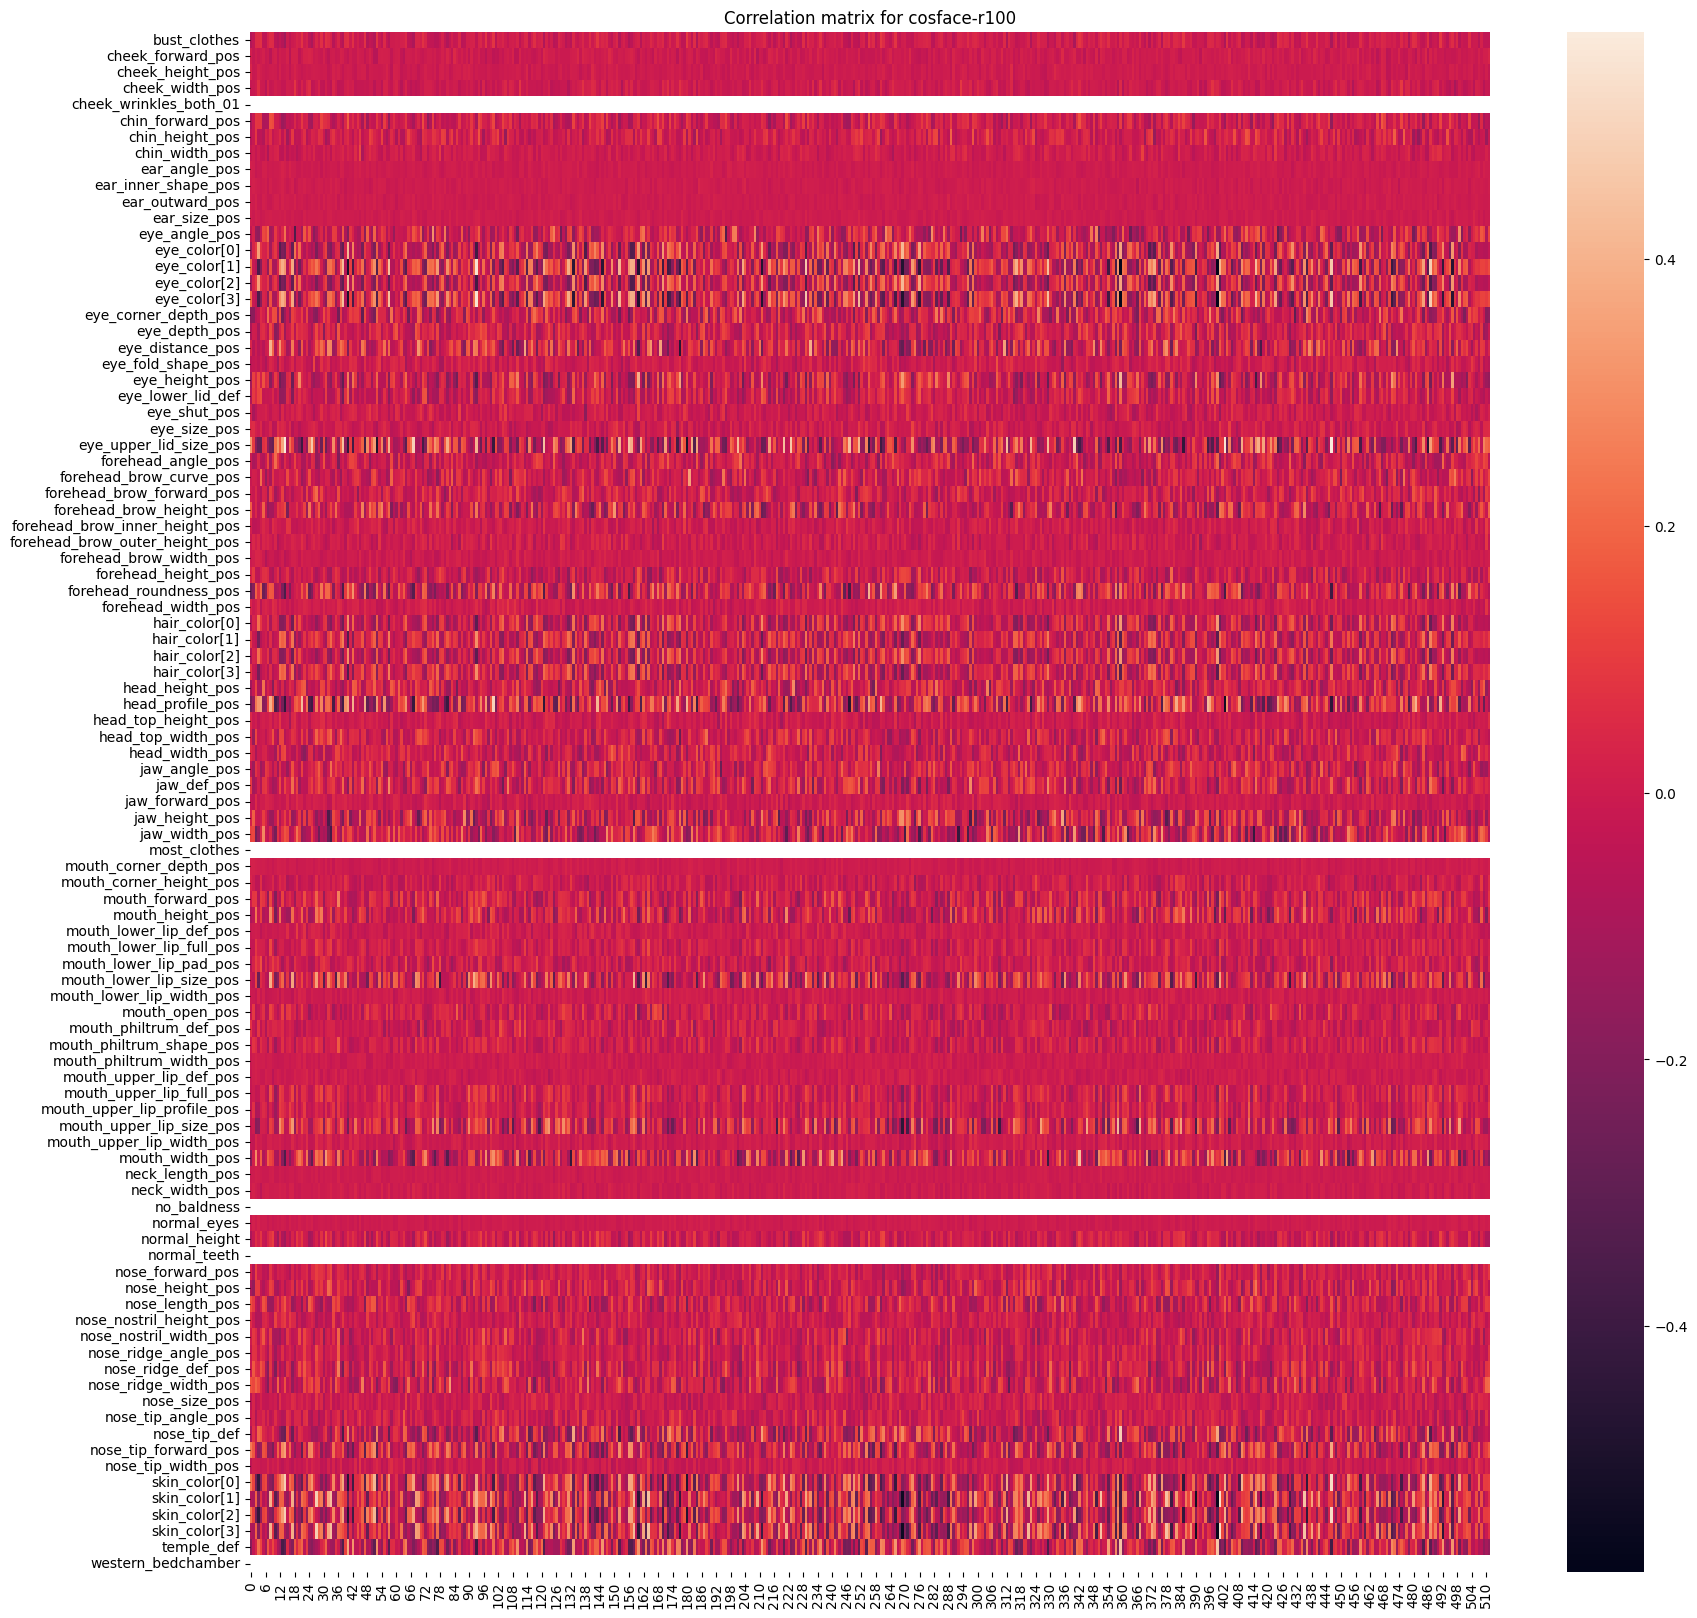

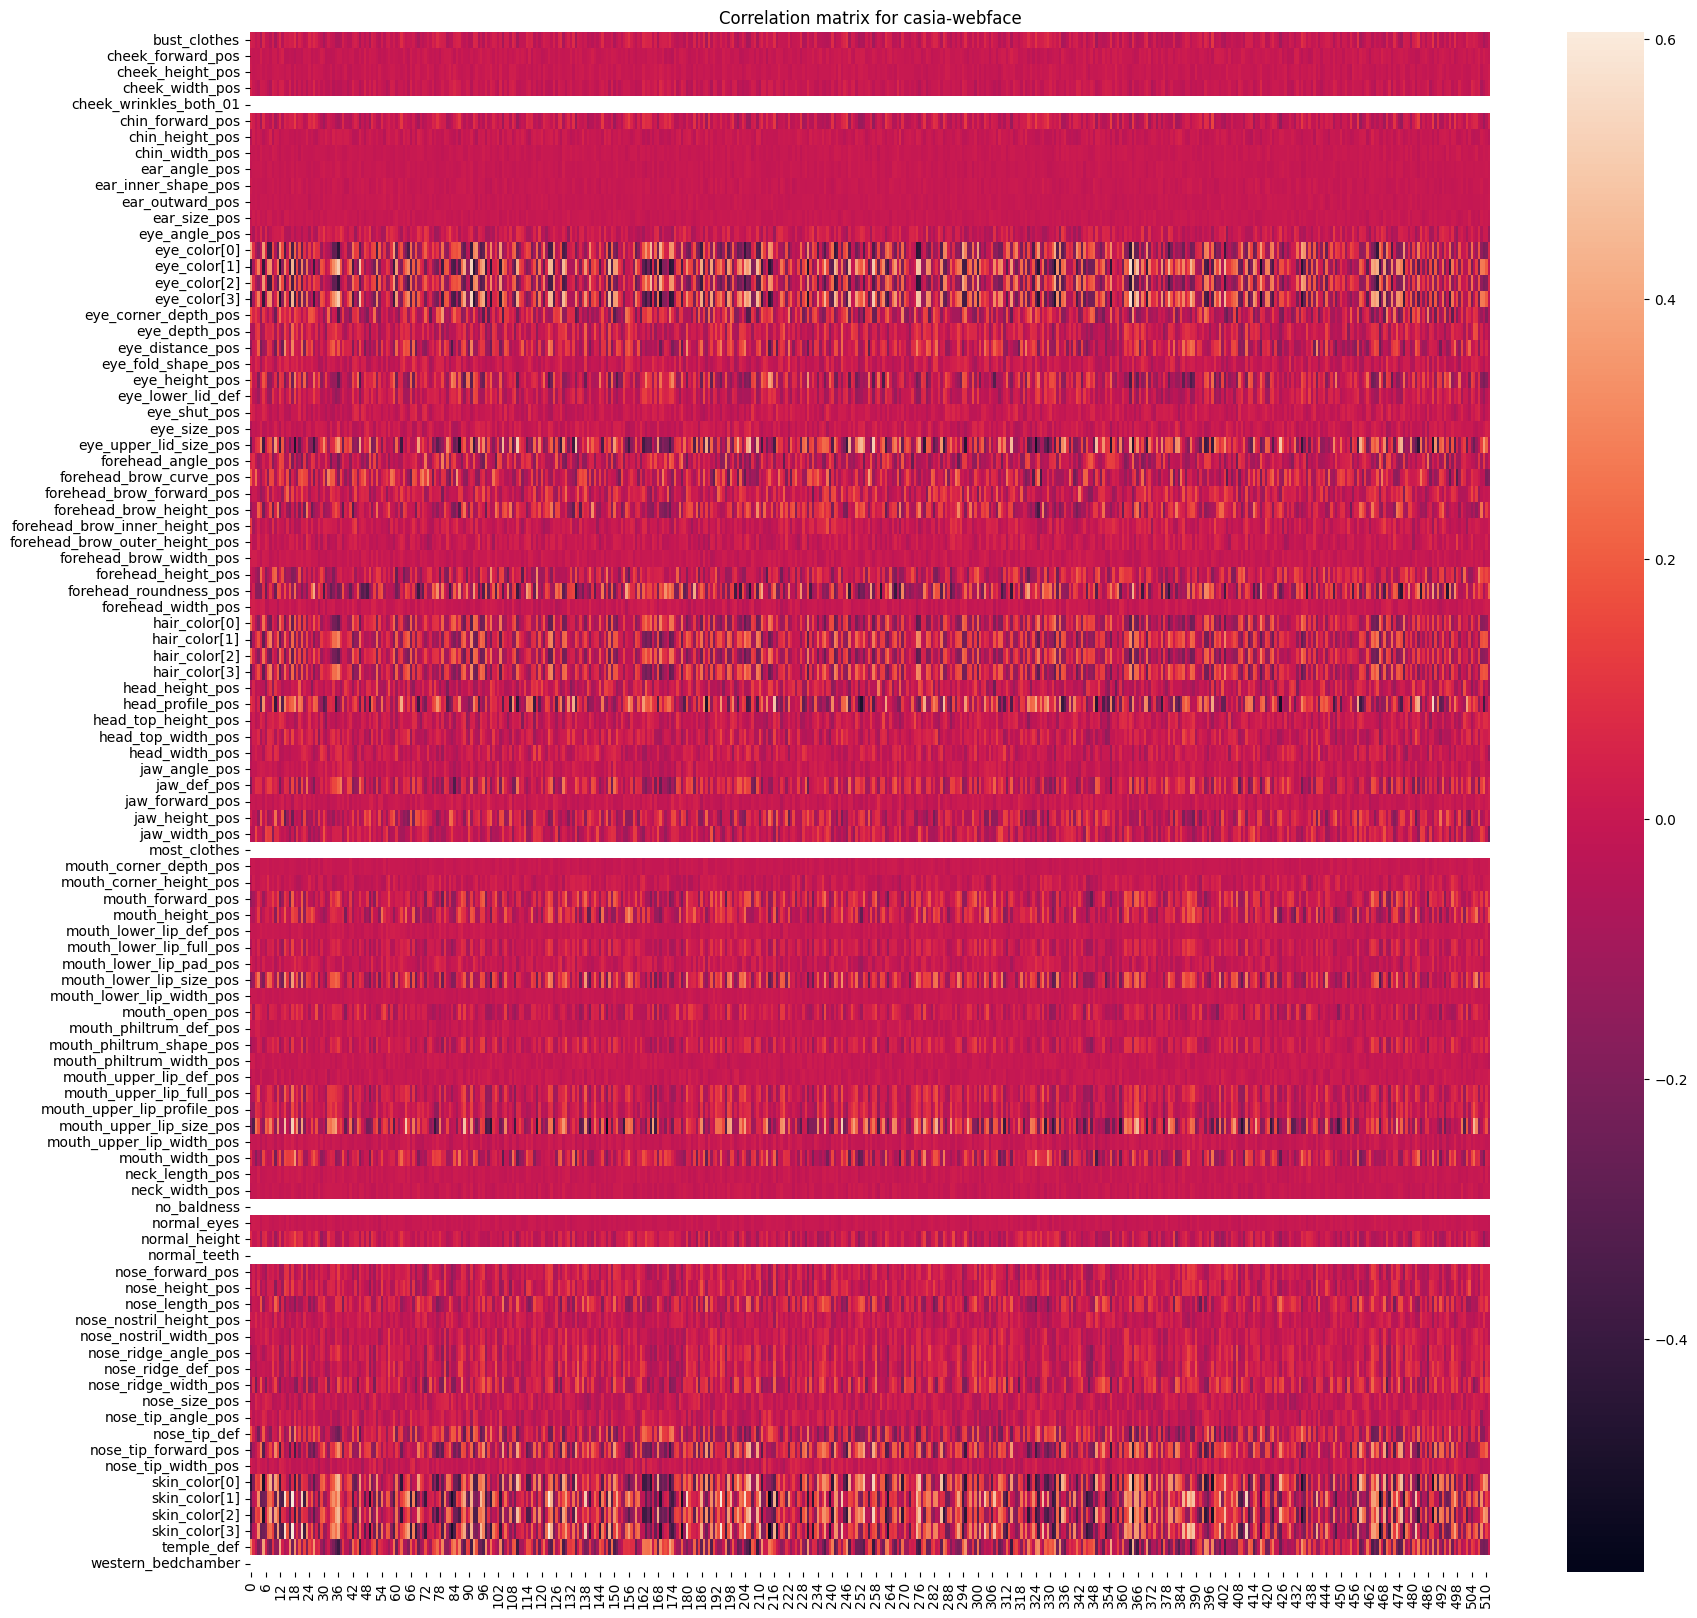

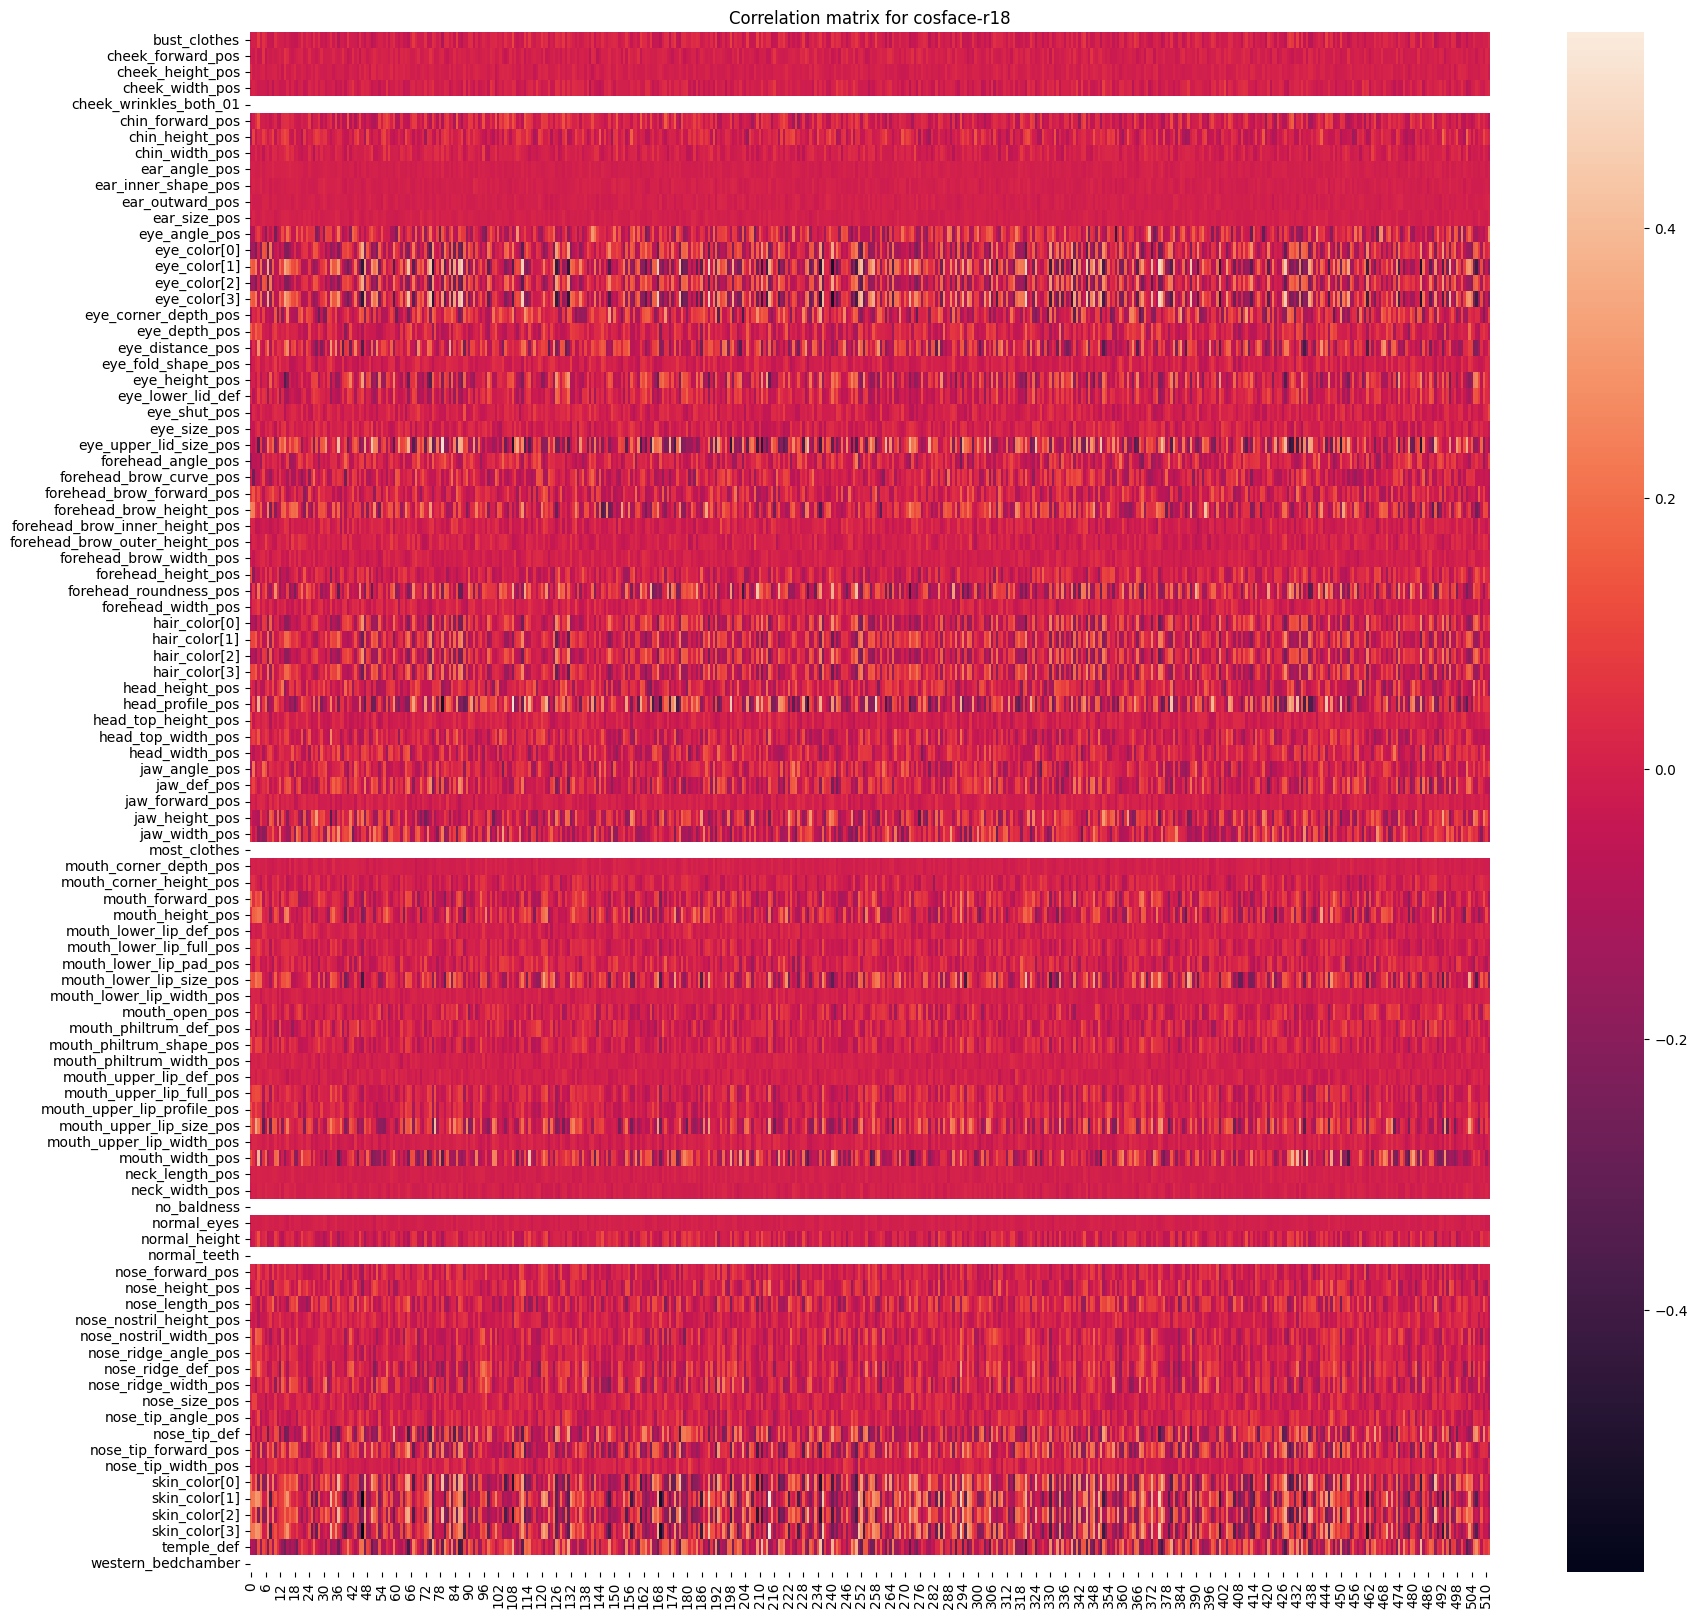

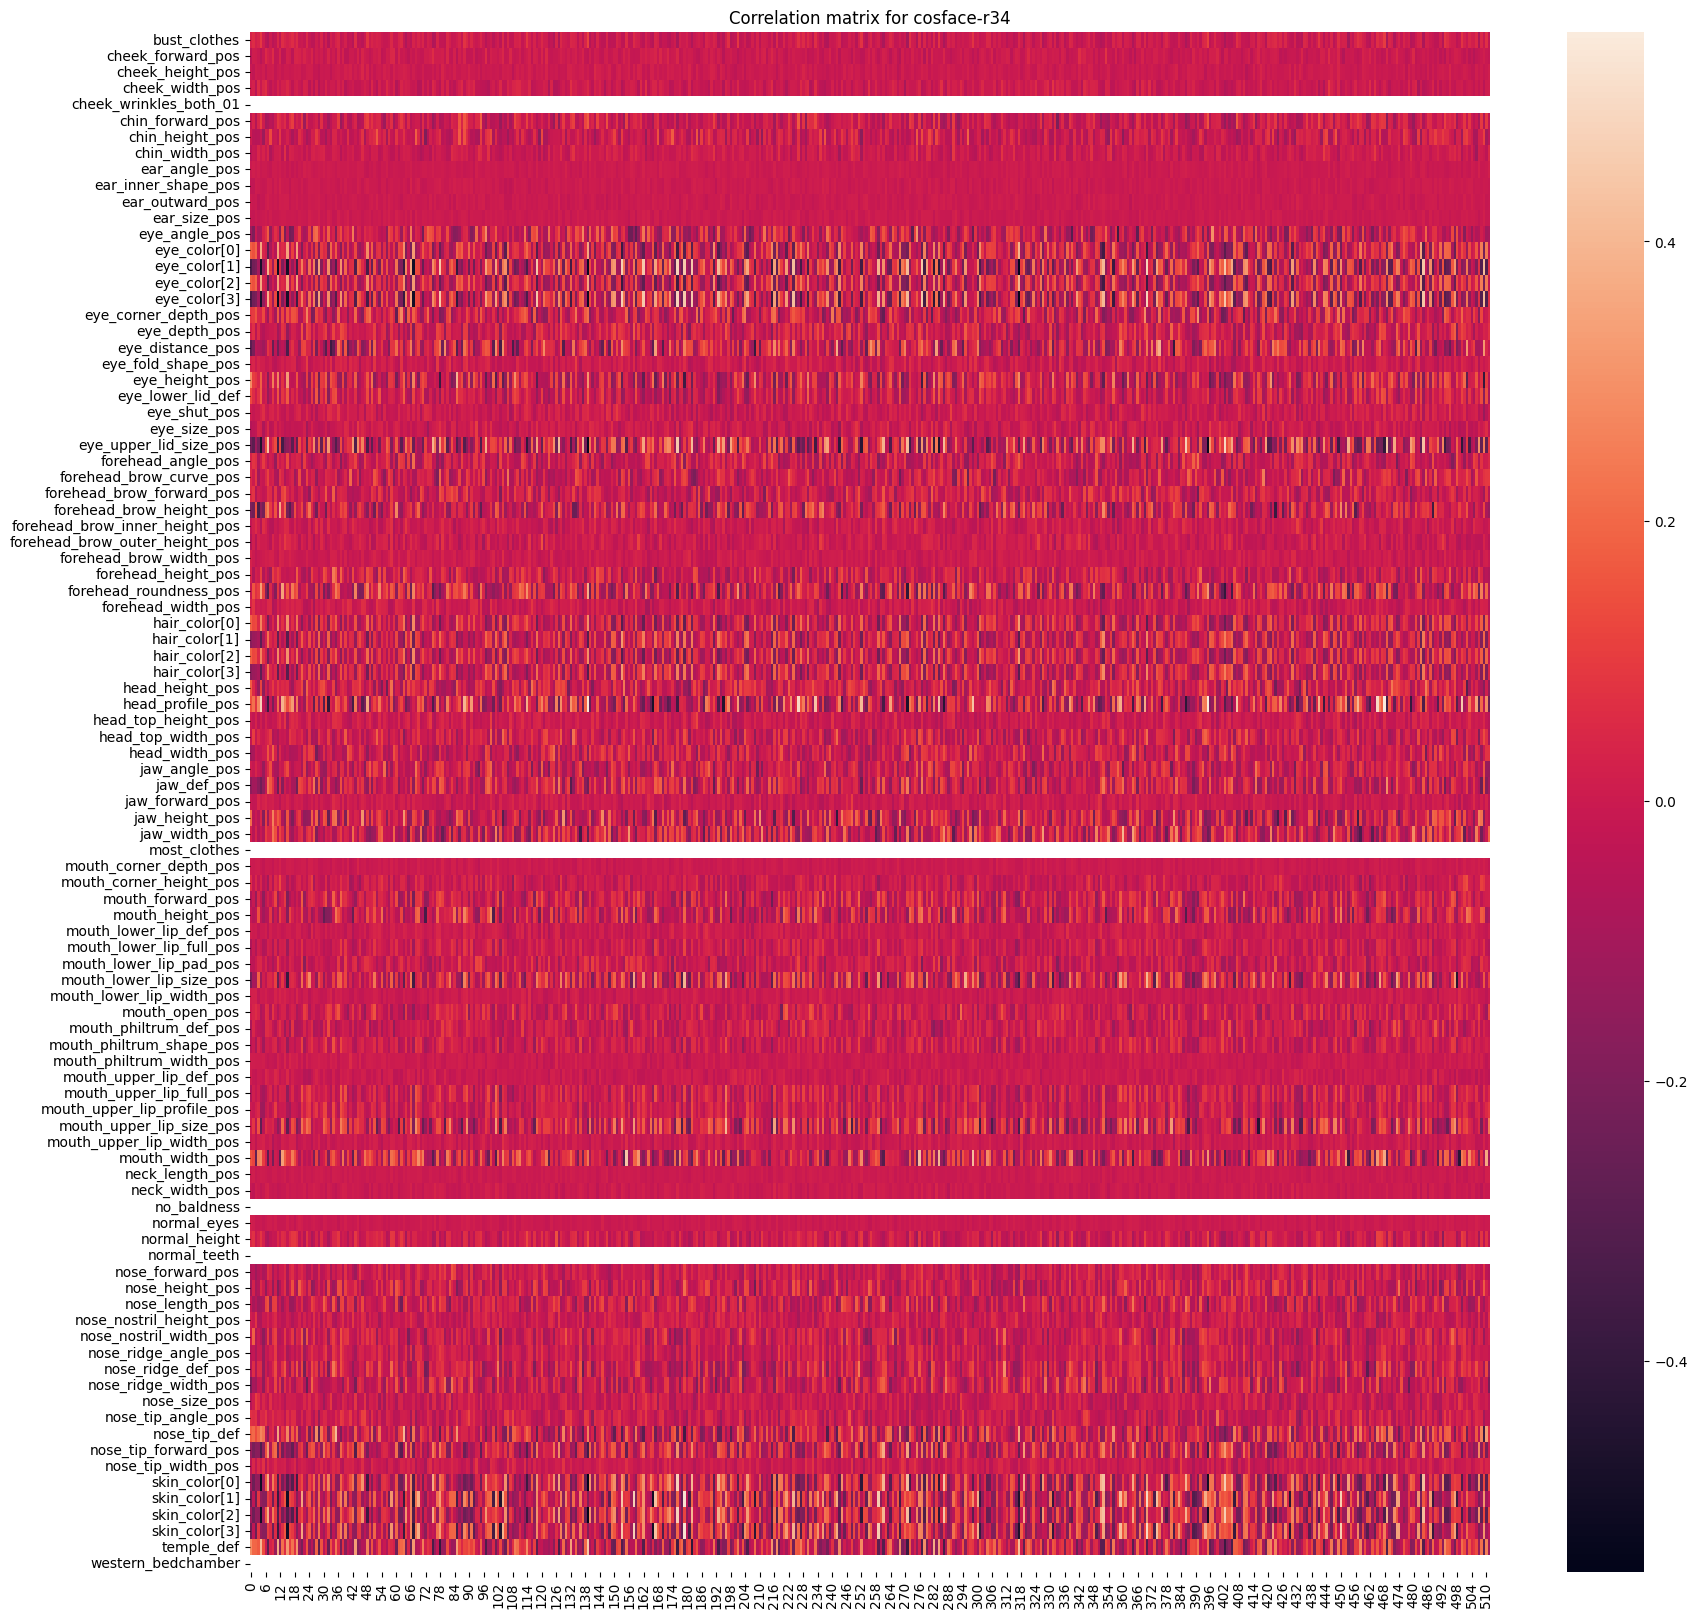

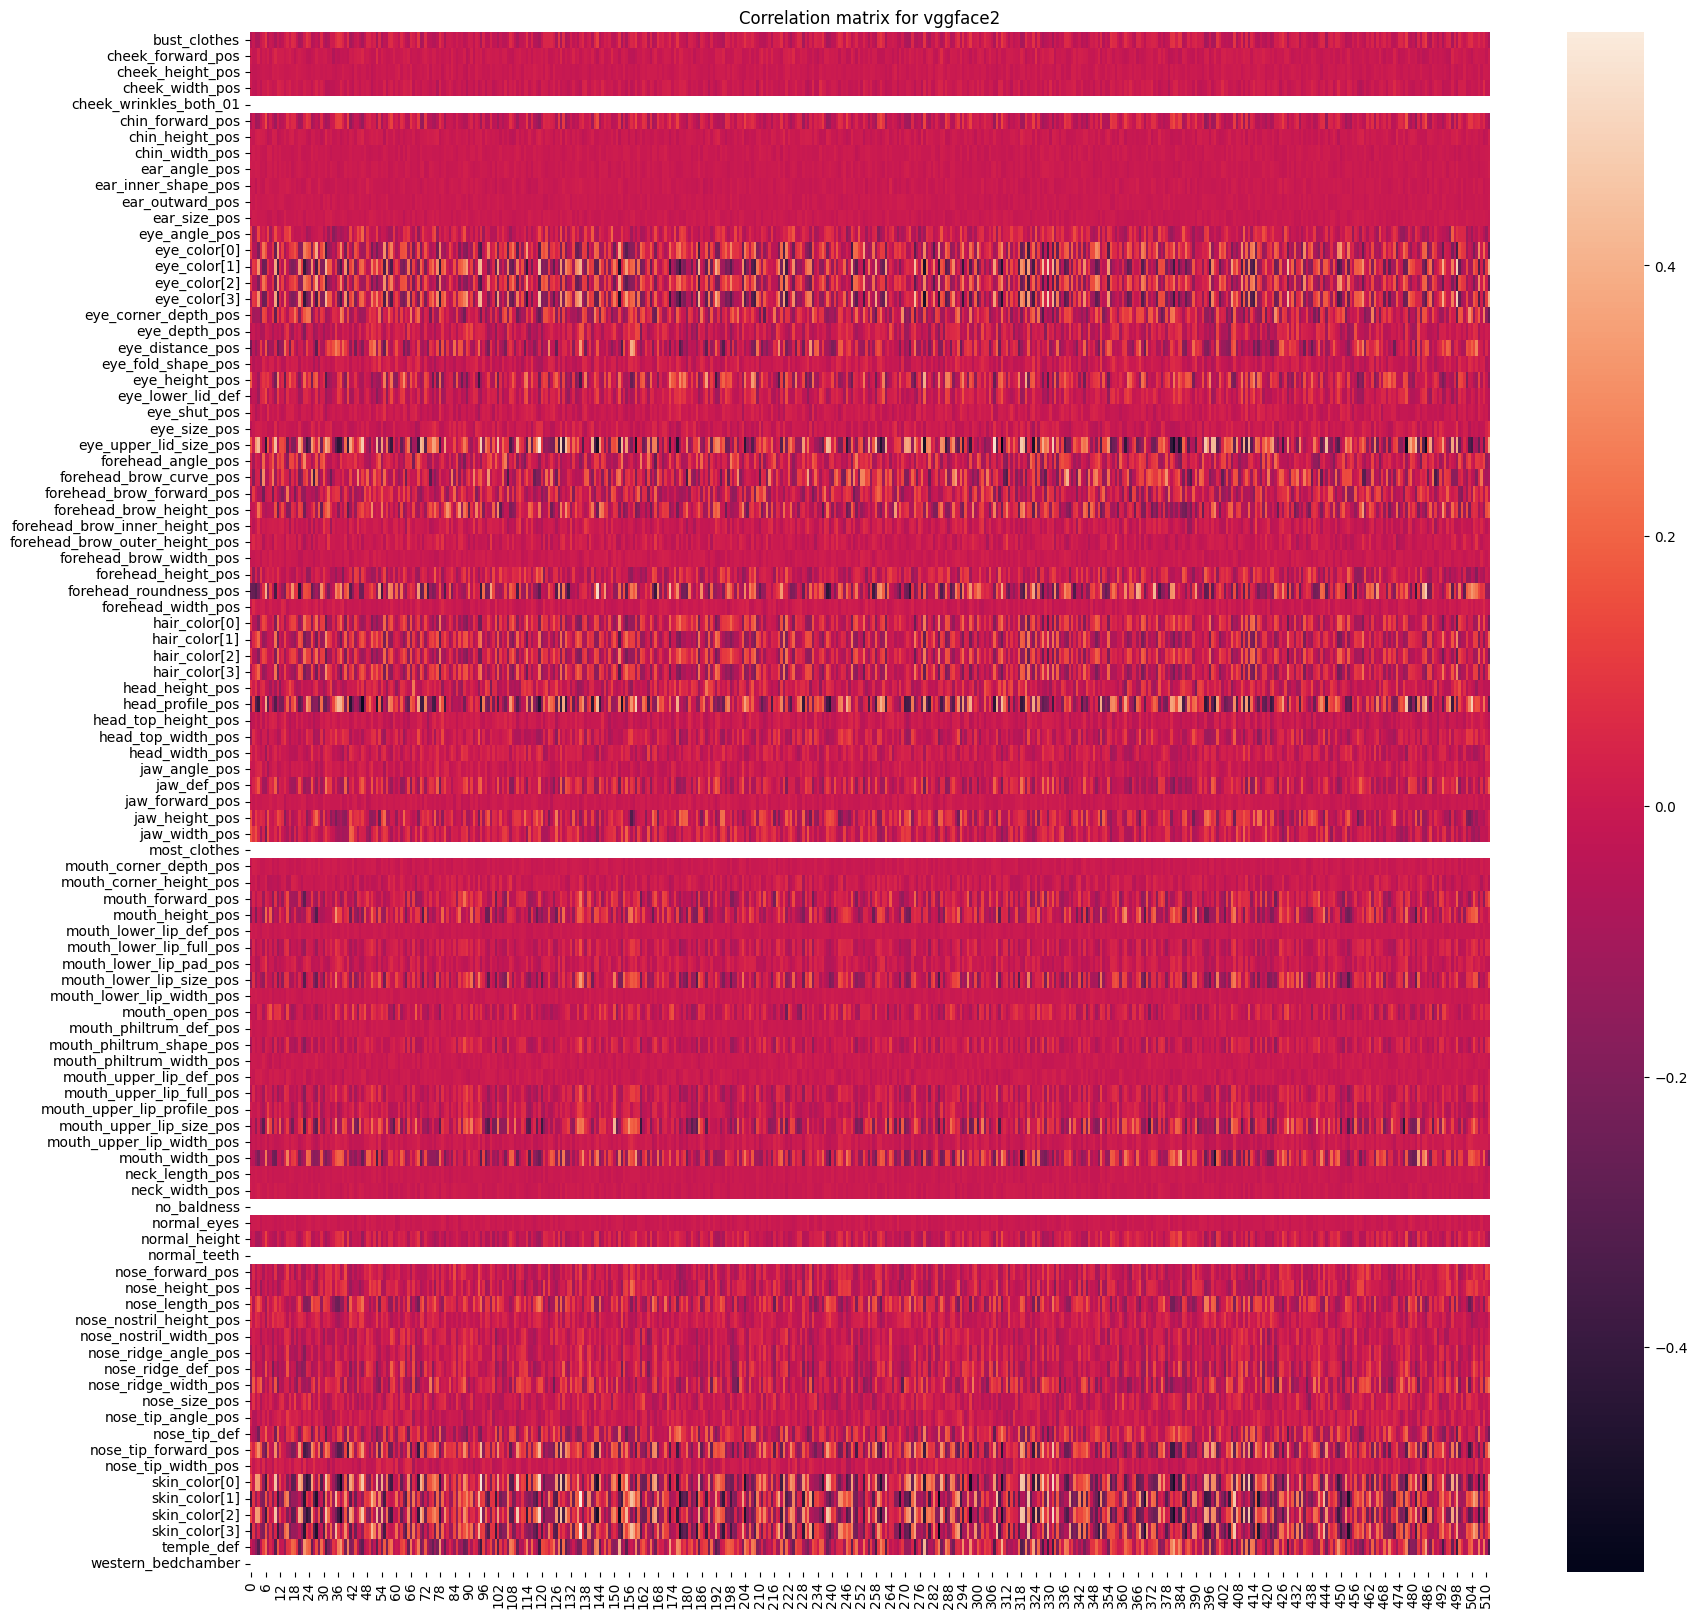

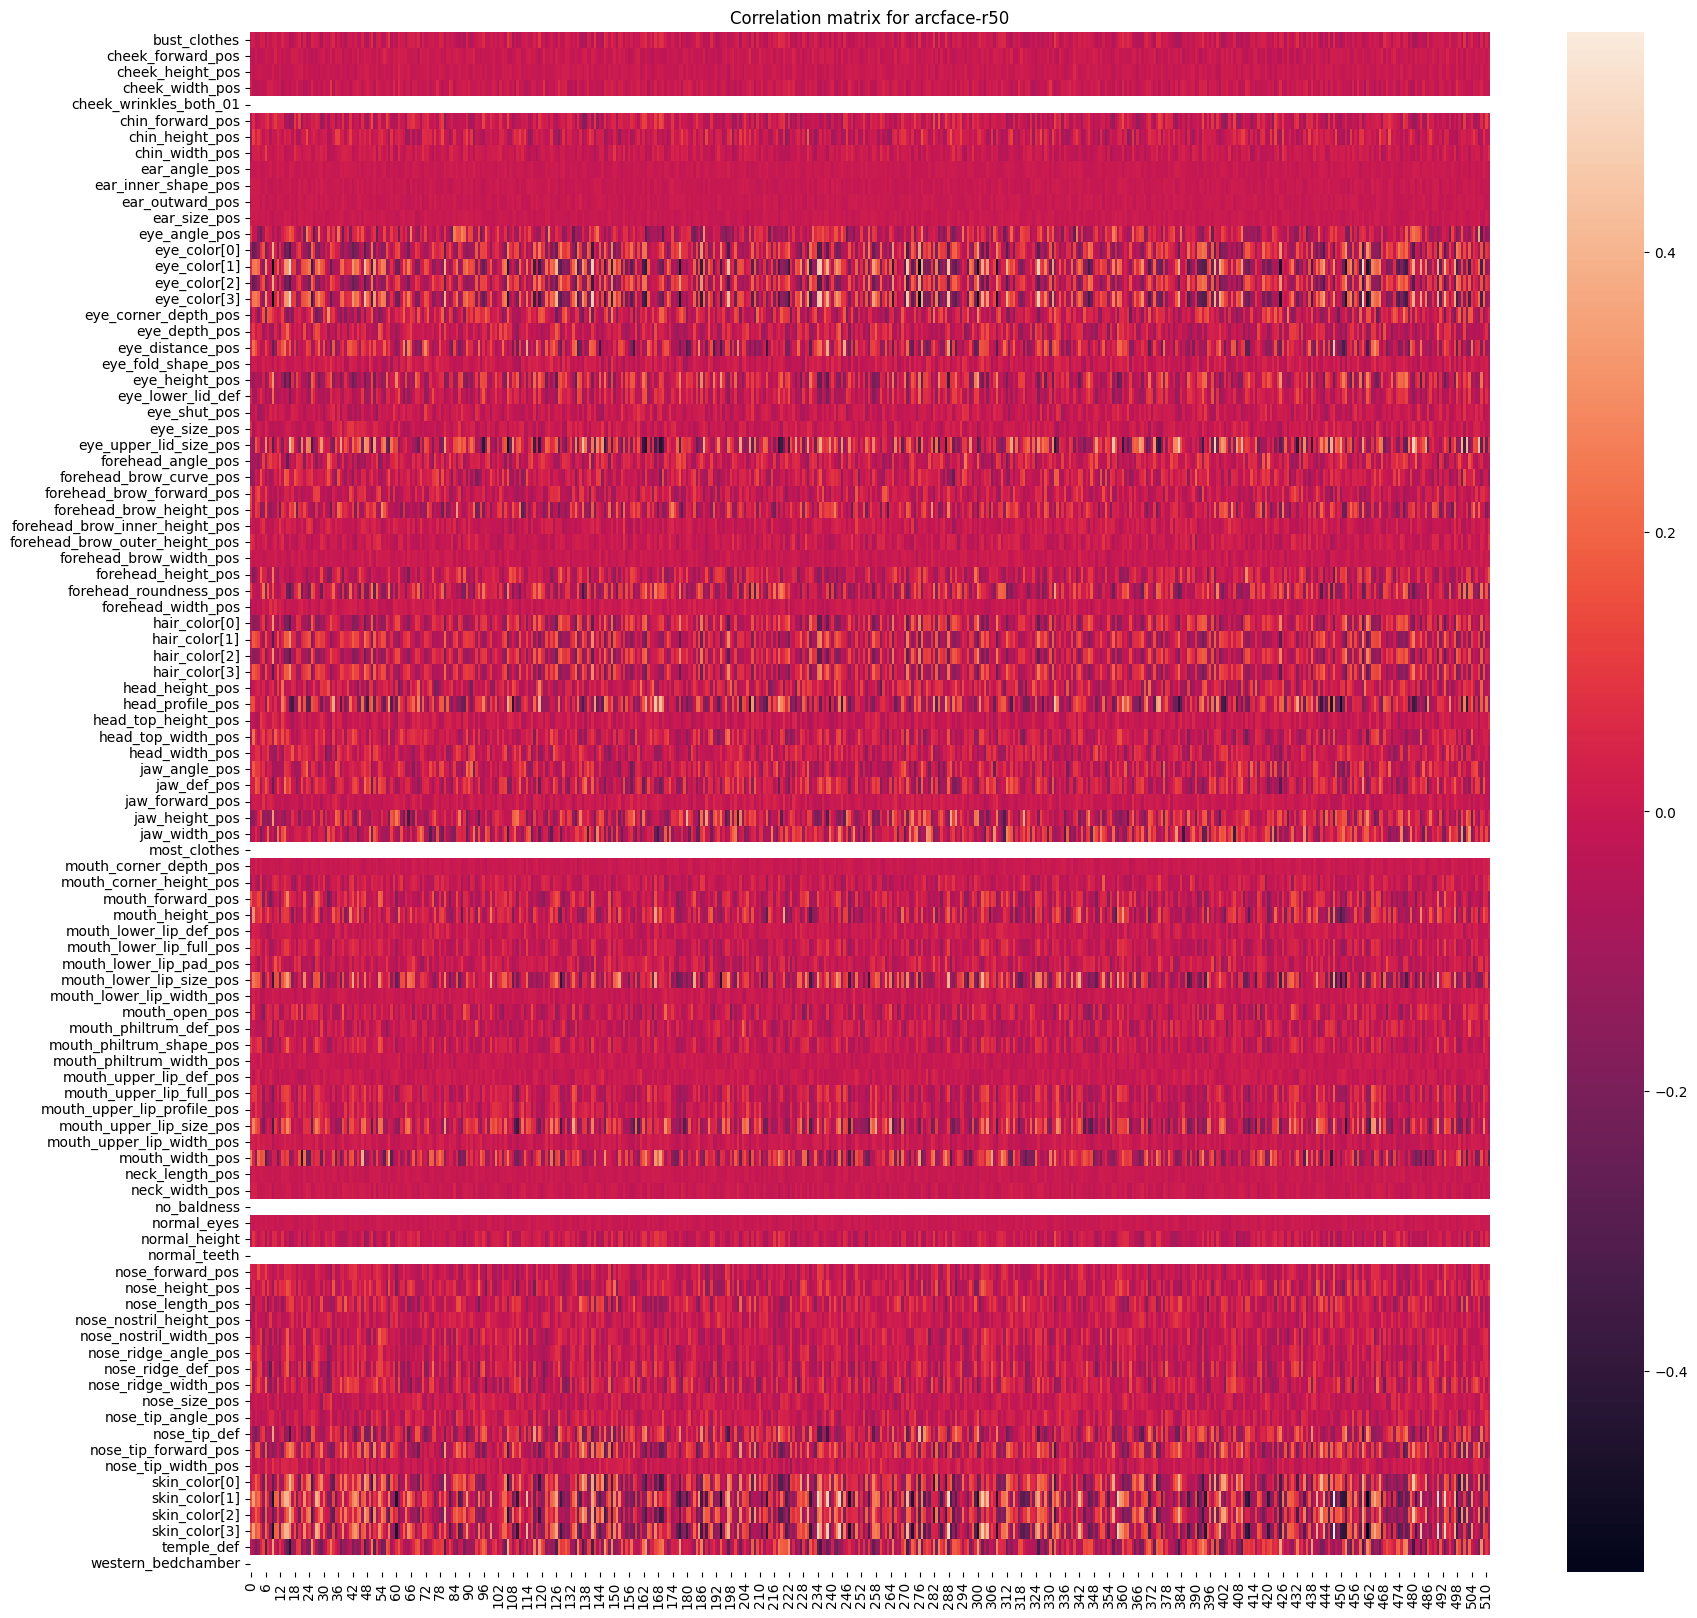

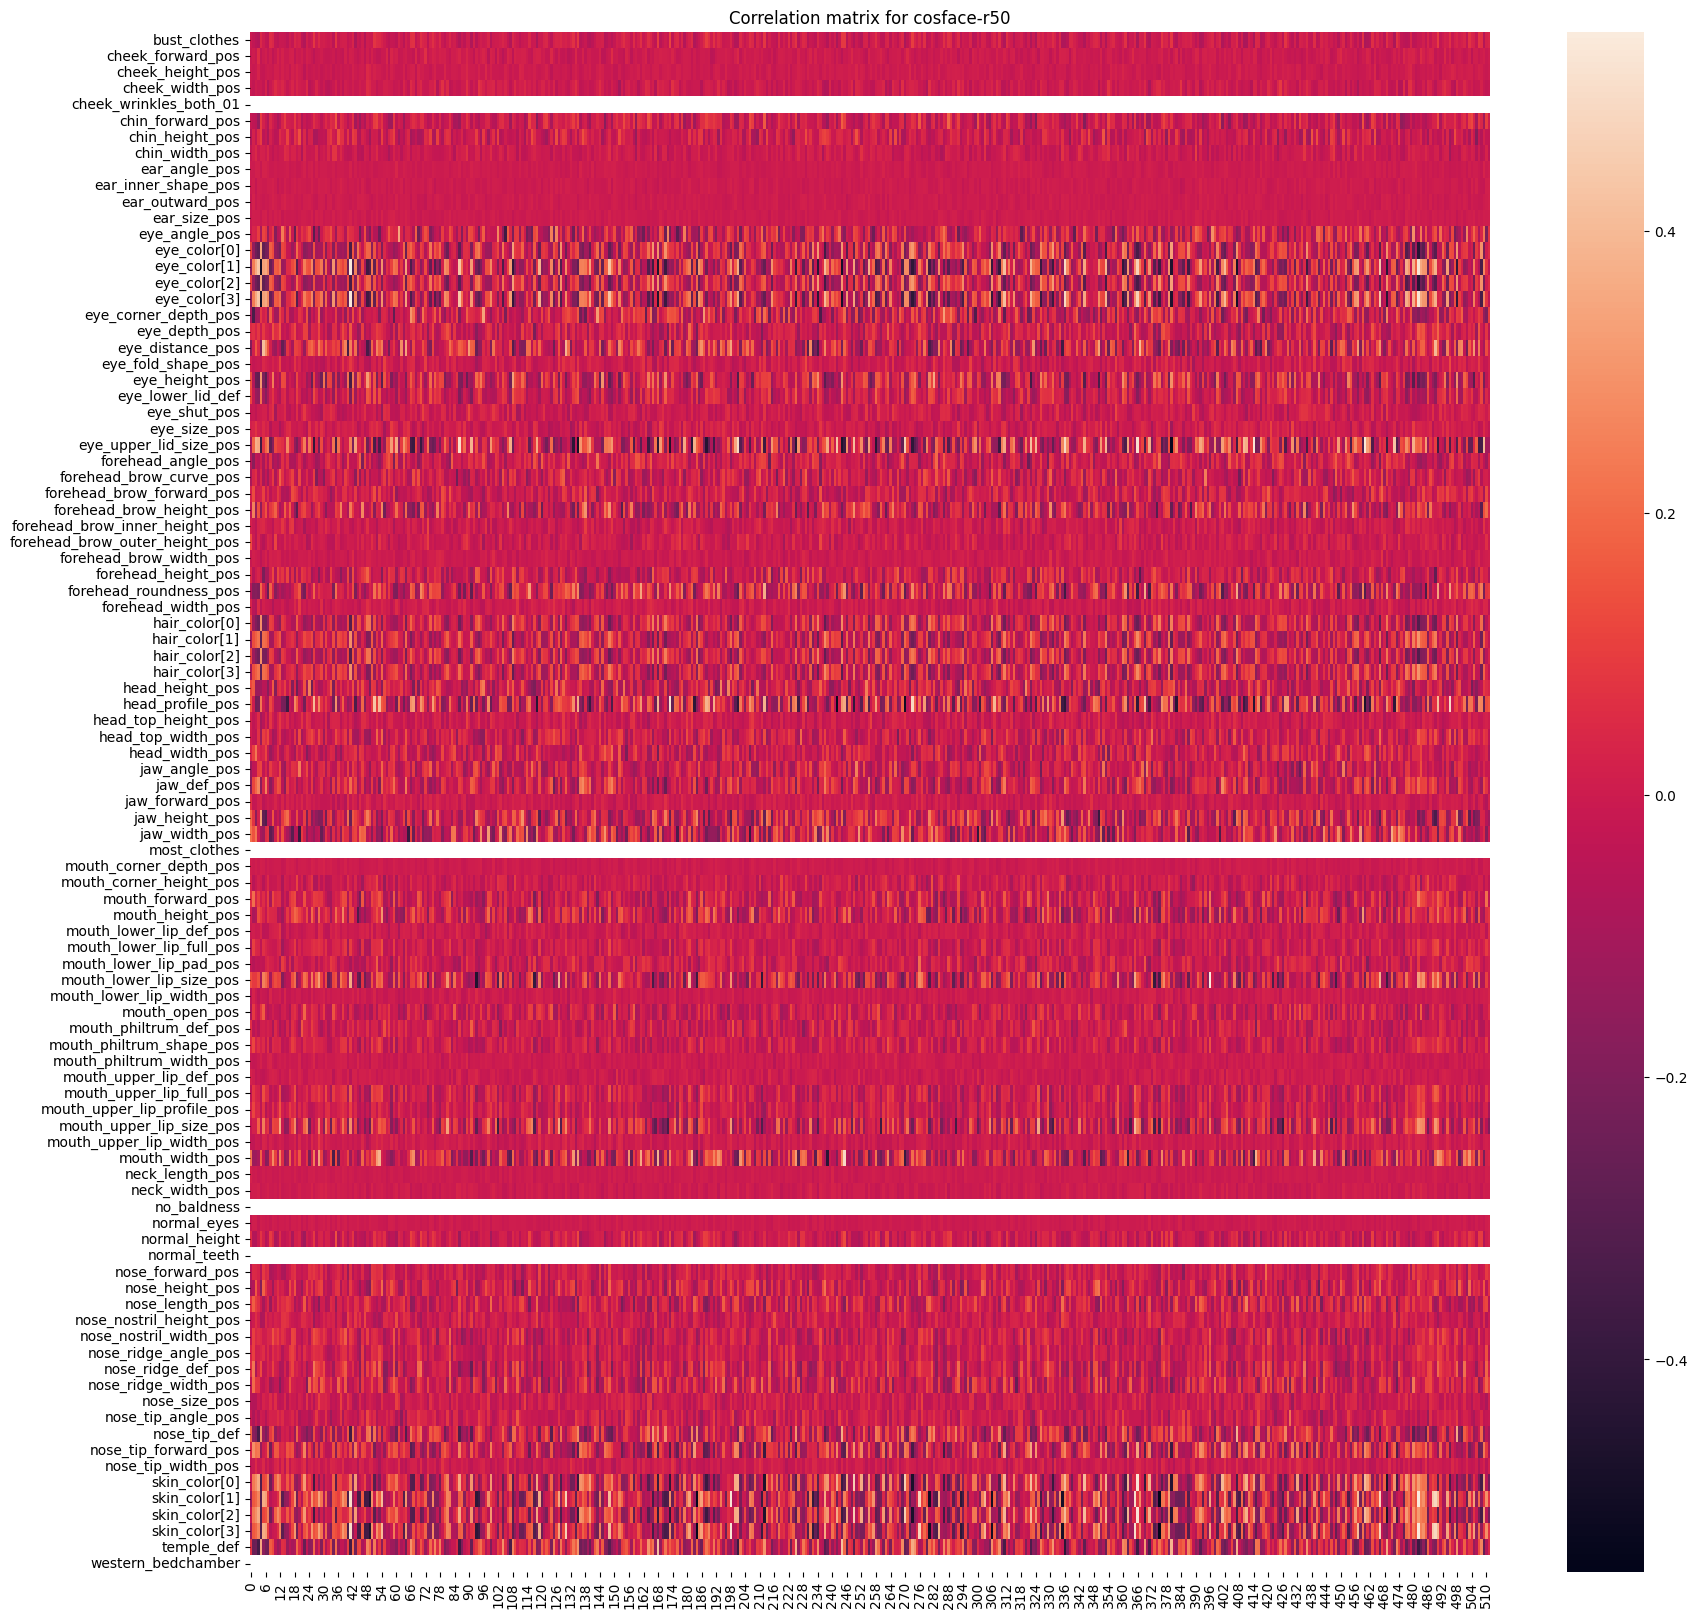

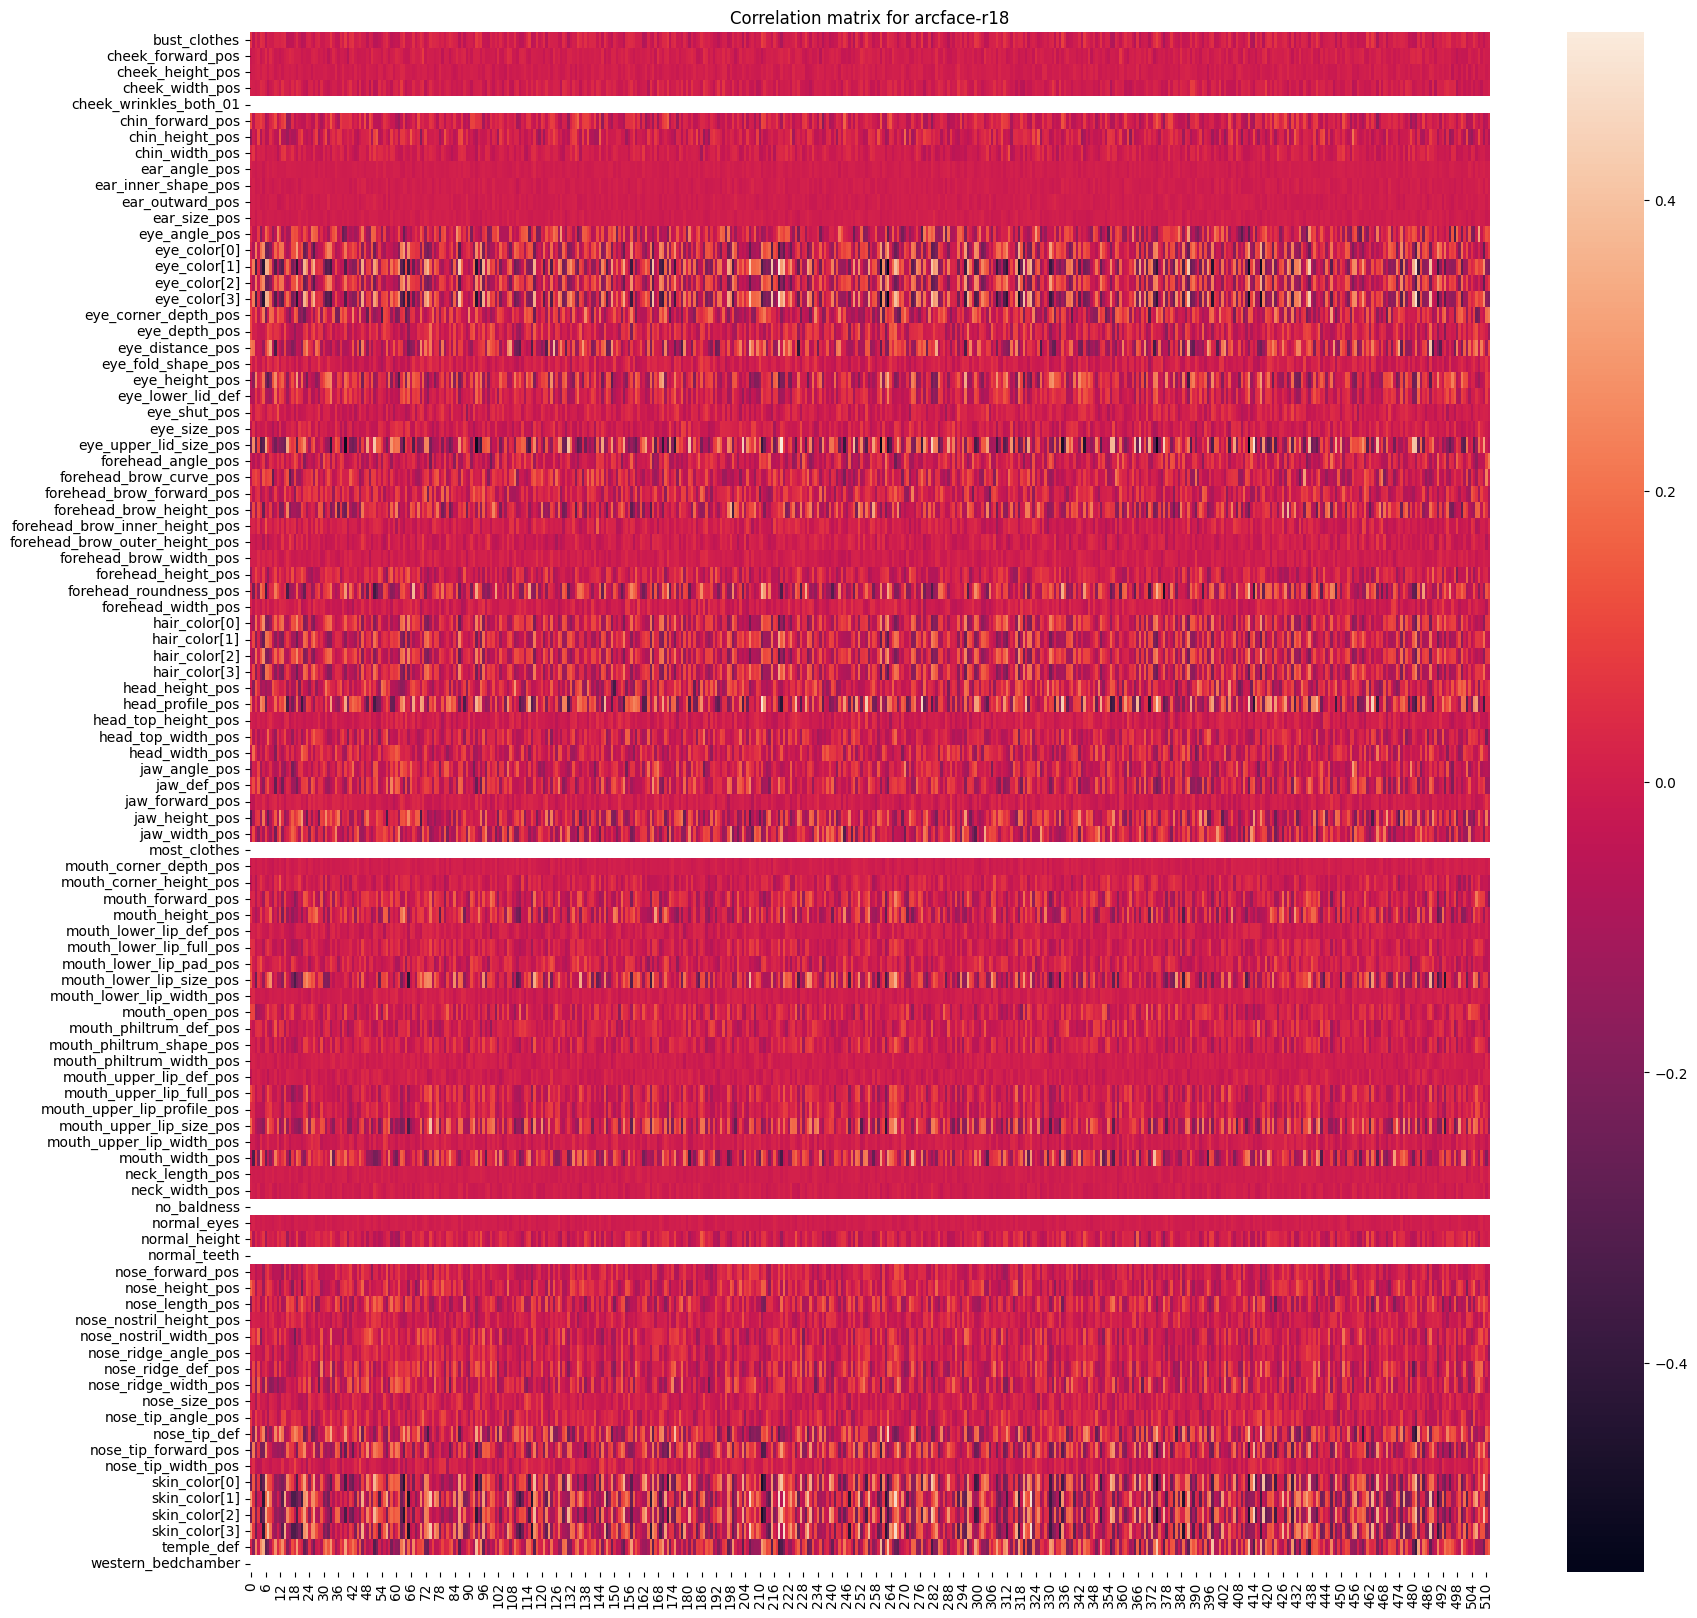

In [28]:
# display correlation matrix for each model
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, correlations in model2correlations.items():
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlations, yticklabels=genes_to_use)
    plt.title(f"Correlation matrix for {model_name}")
    plt.show()